In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as spo
import psi4
import v3d

In [2]:
#will use psi4 to compute energies, setting output file and some basic variables. 
psi4.core.set_output_file('angles.dat')
theory = 'mp2/6-31G*'
bohr2ang = 0.529177
rad2deg = 180.0/np.pi
psi4.core.set_num_threads(10)

In [3]:
#optimized coordinates of the molecule from a previous calc
azi = """
0 1
    C           -1.372186183321    -2.010860020902    -0.886820192828
    C           -0.173158673000    -1.298344357907    -0.406115006426
    N            0.786309071860    -1.384810968974     0.420697487368
    C            0.662837700048    -0.111043752576    -0.491918176988
    H            1.422532833369    -0.002132476819    -1.261568419806
    C            0.271415655367     1.154529325936     0.168585840901
    O           -0.638034693748     0.950769479245     1.162558403008
    O            0.686902544636     2.258017066085    -0.144478115352
    H           -1.457401352716    -2.978238526949    -0.387585199421
    H           -1.313874303487    -2.157164437091    -1.968871402470
    H           -2.260422649854    -1.409349289546    -0.673788389312
    H           -0.815494634684     1.839688017493     1.533442847642
"""


In [18]:
#what coordinates are we optimizing
coords = [
    (2,  4,  6),
    (2,  4,  3),
    (2,  4,  5),
    (6,  4,  3),
    (6,  4,  5),
    (3,  4,  5),
]

opt_coords = np.zeros(len(coords))
#print the optimized values of these coordinates:
#also, save these values for later
azi_geo = psi4.geometry(azi)
for item, trio in enumerate(coords):
    opt_coords[item] = v3d.angle((azi_geo.to_arrays()[0])[trio[0]-1],
                                 (azi_geo.to_arrays()[0])[trio[1]-1],
                                 (azi_geo.to_arrays()[0])[trio[2]-1])*rad2deg
    print(coords[item], opt_coords[item])

opt_energy = psi4.energy(theory)

(2, 4, 6) 121.30244737053357
(2, 4, 3) 49.41653448641349
(2, 4, 5) 121.6855487381018
(6, 4, 3) 117.03585143566144
(6, 4, 5) 114.52684863523099
(3, 4, 5) 115.94048230842184


In [5]:
#perform constrained optimizations in psi4
#careful to collect actual, not ideal, optimized coordinate values here. 
#these wont always be the same as the target values
#because of "fixed" rather than "frozen" contraint
t_real = np.zeros((len(coords), 9))
#collecting energies here
energies = np.zeros((len(coords), 9))
    
for item, trio in enumerate(coords):
    
    #define geometry
    azi_geo = psi4.geometry(azi)
    #get optimized coordinate values
    t0 = v3d.angle((azi_geo.to_arrays()[0])[trio[0]-1],
                   (azi_geo.to_arrays()[0])[trio[1]-1],
                   (azi_geo.to_arrays()[0])[trio[2]-1])*rad2deg
    
    #increased coordinate value half of scan
    tplus = np.linspace(t0, t0+15, 5)
    #decreased coordinate value half of scan
    tminus = np.linspace(t0-15, t0, 5)[:-1]
    #putting them together
    t = np.append(tminus, tplus)
        
    azi_geo = psi4.geometry(azi)
    #selecting left half. This set up 
    #lets the optimization start with the optimized
    #coordinates, then move away from them
    #hence, np.flip.
    for i, n in enumerate(np.flip(tminus)):
        #options for geometry opt
        options={'scf_type':'df',
             'g_convergence':'gau_loose',
             'freeze_core':'true',
             'opt_coordinates':'both',
             #selecting atoms I care about and target distance
             "fixed_bend":"{a} {b} {c} {d}".format(a=trio[0], 
                                                   b=trio[1], 
                                                   c=trio[2],
                                                   d=n),
             "geom_maxiter" : 500,
             "full_hess_every" : 50,
             "dynamic_level" : 1}
        psi4.set_options(options)
        energies[item, 3-i] = psi4.optimize(theory)
        t_real[item, 3-i] = v3d.angle((azi_geo.to_arrays()[0])[trio[0]-1],
                                      (azi_geo.to_arrays()[0])[trio[1]-1],
                                      (azi_geo.to_arrays()[0])[trio[2]-1])*rad2deg
        print(np.abs(t_real[item, 3-i] - t[3-i]))
        
    azi_geo = psi4.geometry(azi)
    #generally the same as above but for the above half of the scan
    for i, n in enumerate(tplus):
        options={'scf_type':'df',
             'g_convergence':'gau_loose',
             'freeze_core':'true',
             'opt_coordinates':'both',
             "fixed_bend":"{a} {b} {c} {d}".format(a=trio[0], 
                                                   b=trio[1], 
                                                   c=trio[2],
                                                   d=n),           
             "geom_maxiter" : 500,
             "full_hess_every" : 50,
             "dynamic_level" : 1}
        psi4.set_options(options)
        energies[item, 4+i] = psi4.optimize(theory)
        t_real[item, 4+i] = v3d.angle((azi_geo.to_arrays()[0])[trio[0]-1],
                                      (azi_geo.to_arrays()[0])[trio[1]-1],
                                      (azi_geo.to_arrays()[0])[trio[2]-1])*rad2deg
        print(np.abs(t_real[item, 4+i] - t[4+i]))

 61 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 '487.3410' '605.6247']
Optimizer: Optimization complete!
0.8332188920546599
 61 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 '487.7817' '606.7434']
Optimizer: Optimization complete!
1.7302148703373206
 61 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 '488.2054' '607.9220']


Too many bad steps.


Optimizer: Optimization complete!
3.127363813968728
 61 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 '488.2818' '608.9584']


Too many bad steps.


Optimizer: Optimization complete!
4.27663170335866
 61 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 '487.3398' '605.6249']
Optimizer: Optimization complete!
0.0
 61 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 '487.3406' '605.6214']
Optimizer: Optimization complete!
0.6859415913252889
 61 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 '485.4636' '606.2083']


Too many bad steps.
Too many bad steps.


Optimizer: Optimization complete!
1.5188965427932857
 61 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 '485.9786' '603.3785']
Optimizer: Optimization complete!
2.3753178395993473
 61 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 '484.5945' '603.6778']
Optimizer: Optimization complete!
3.190177794873165
 61 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 '487.3404' '605.6245']
Optimizer: Optimization complete!
2.8266150460487083
 61 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 

Too many bad steps.


At level 1: Red. Int., RFO, no backsteps, dynamic trust
At level 1: Red. Int., RFO, no backsteps, dynamic trust
At level 1: Red. Int., RFO, no backsteps, dynamic trust
At level 1: Red. Int., RFO, no backsteps, dynamic trust
At level 1: Red. Int., RFO, no backsteps, dynamic trust
At level 1: Red. Int., RFO, no backsteps, dynamic trust
At level 1: Red. Int., RFO, no backsteps, dynamic trust
At level 1: Red. Int., RFO, no backsteps, dynamic trust
At level 1: Red. Int., RFO, no backsteps, dynamic trust
At level 1: Red. Int., RFO, no backsteps, dynamic trust
At level 1: Red. Int., RFO, no backsteps, dynamic trust
At level 2: Red. Int., RFO, backsteps, smaller trust.
At level 1: Red. Int., RFO, no backsteps, dynamic trust
At level 1: Red. Int., RFO, no backsteps, dynamic trust
At level 1: Red. Int., RFO, no backsteps, dynamic trust
At level 1: Red. Int., RFO, no backsteps, dynamic trust
At level 1: Red. Int., RFO, no backsteps, dynamic trust
At level 2: Red. Int., RFO, backsteps, smaller tru

Too many bad steps.
Too many bad steps.
Too many bad steps.
Too many bad steps.


Optimizer: Optimization complete!
2.6785952739845555
 61 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 '487.3405' '605.6255']
Optimizer: Optimization complete!
0.0
 61 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 '487.3402' '605.6213']
Optimizer: Optimization complete!
0.5708362478727764
 61 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 '488.4440' '606.1345']
Optimizer: Optimization complete!
1.4134444413182194
 61 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37

Too many bad steps.


Optimizer: Optimization complete!
1.6634665969270515
 61 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 '498.6598' '604.9021']


Too many bad steps.


Optimizer: Optimization complete!
2.4478158915080286
 61 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 '504.8216' '603.0081']


Too many bad steps.
Too many bad steps.


cksteps, smaller trust.
At level 2: Red. Int., RFO, backsteps, smaller trust.
At level 2: Red. Int., RFO, backsteps, smaller trust.
At level 2: Red. Int., RFO, backsteps, smaller trust.
At level 2: Red. Int., RFO, backsteps, smaller trust.
At level 3: Red. Int. + XYZ, RFO, backsteps, smaller trust.
At level 3: Red. Int. + XYZ, RFO, backsteps, smaller trust.
At level 3: Red. Int. + XYZ, RFO, backsteps, smaller trust.
At level 3: Red. Int. + XYZ, RFO, backsteps, smaller trust.
At level 3: Red. Int. + XYZ, RFO, backsteps, smaller trust.
At level 3: Red. Int. + XYZ, RFO, backsteps, smaller trust.
At level 4: XYZ, RFO, backsteps, larger trust.
At level 4: XYZ, RFO, backsteps, larger trust.
At level 4: XYZ, RFO, backsteps, larger trust.
At level 4: XYZ, RFO, backsteps, larger trust.
At level 4: XYZ, RFO, backsteps, larger trust.
At level 4: XYZ, RFO, backsteps, larger trust.
At level 4: XYZ, RFO, backsteps, larger trust.
At level 4: XYZ, RFO, backsteps, larger trust.
At level 4: XYZ, RFO, ba

Too many bad steps.
Too many bad steps.
Too many bad steps.


Optimizer: Optimization complete!
3.0965491937764824
 61 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 '487.3401' '605.6254']
Optimizer: Optimization complete!
0.0
 61 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 '487.3405' '605.6213']
Optimizer: Optimization complete!
0.8819309207103316
 61 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 '482.4039' '605.3659']
Optimizer: Optimization complete!
1.7413445697770555
 61 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37

Too many bad steps.


Optimizer: Optimization complete!
2.9752811481385777
 61 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 '487.3407' '605.6255']
Optimizer: Optimization complete!
0.0
 61 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 '487.3400' '605.6213']
Optimizer: Optimization complete!
0.805397022141392
 61 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 '488.0864' '607.7940']
Optimizer: Optimization complete!
1.5902545980845417
 61 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 

In [6]:
np.loadtxt('angle_energies.dat', energies)
np.loeadtxt('angle_thetas.dat', t_real)

In [19]:
energies_norm = (energies-opt_energy)*627.503

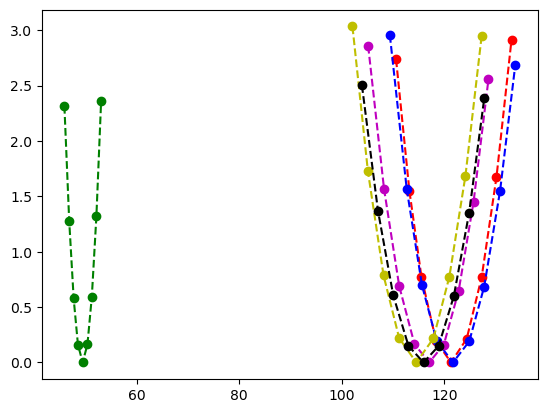

In [20]:
#collected data plots
colors = ['r', 'g', 'b', 'm', 'y', 'k']

for i in range(len(coords)):
    plt.plot(t_real[i], energies_norm[i], '--o', color=colors[i]) 
               #plt.ylim(0, 10)
               #plt.xlim(1.0, 2)

In [21]:
def vbond(t, k, t0):
    return k*((t-t0)/rad2deg)**2

In [28]:
parms = []
                 
for i in range(len(coords)):
    parms.append(spo.curve_fit(vbond, 
                               t_real[i], 
                               energies_norm[i], 
                               p0=[100, 120]))

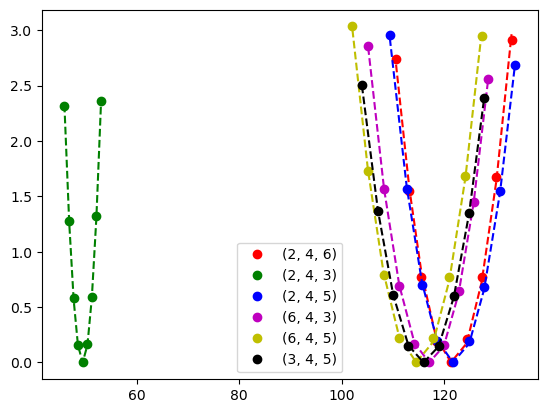

In [29]:
#fitted data plots
colors = ['r', 'g', 'b', 'm', 'y', 'k']

for i in range(len(coords)):
    plt.plot(t_real[i], energies_norm[i], 'o', color=colors[i], label=str(coords[i])) 
    plt.plot(t_real[i], vbond(t_real[i], *parms[i][0]), '--', color=colors[i])
plt.legend()
#plt.ylim(0, 50)
#plt.xlim(1.0, 2)

In [30]:
for i in range(len(coords)):
    print('For the angle between atoms ', str(coords[i]))
    print('the force constant is ', str(parms[i][0][0]), ' p/m ', np.sqrt(np.diag(parms[i][1]))[0], 'kcal/mol/rad^2')
    print('and the optimal angle is ', str(parms[i][0][1]), ' p/m ', np.sqrt(np.diag(parms[i][1]))[1], 'degrees')


For the angle between atoms  (2, 4, 6)
the force constant is  73.05394654630726  p/m  0.6348124678596203 kcal/mol/rad^2
and the optimal angle is  121.57151484383068  p/m  0.041982654827442824 degrees
For the angle between atoms  (2, 4, 3)
the force constant is  600.2367812369564  p/m  1.7251183872640006 kcal/mol/rad^2
and the optimal angle is  49.420313385665054  p/m  0.004412412210173761 degrees
For the angle between atoms  (2, 4, 5)
the force constant is  61.76861069415653  p/m  0.30282717389018776 kcal/mol/rad^2
and the optimal angle is  121.83743466199962  p/m  0.02573799023183711 degrees
For the angle between atoms  (6, 4, 3)
the force constant is  64.60057796066641  p/m  0.22647904923927775 kcal/mol/rad^2
and the optimal angle is  117.16005970991175  p/m  0.01769645447015471 degrees
For the angle between atoms  (6, 4, 5)
the force constant is  61.82148136932719  p/m  0.3261043379075206 kcal/mol/rad^2
and the optimal angle is  114.69838296214006  p/m  0.02850442528303279 degrees
F